Table Results:
Sigma      | Gamma=0.1%   | Gamma=0.3%   | Gamma=1.0%   | Best Gamma
----------------------------------------------------------------------
0.2        | 0.003685     | 0.008522     | 0.009430     | 0.01
0.6        | 0.011923     | 0.032983     | 0.081082     | 0.01
1.0        | 0.020061     | 0.057384     | 0.160690     | 0.01


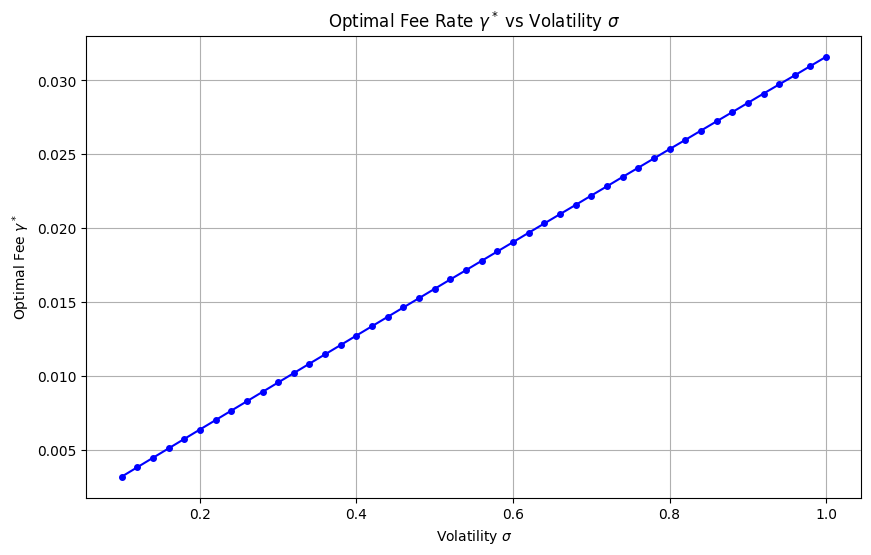

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Parameters
x_t = 1000.0
y_t = 1000.0
k = x_t * y_t
P_t = y_t / x_t 
S_t = 1.0
dt = 1.0 / 365.0 

# Revenue Function 
def calculate_revenue_at_s(s_next, gamma):
    
    upper_bound = P_t / (1.0 - gamma)
    lower_bound = P_t * (1.0 - gamma)
    
    if s_next > upper_bound:
        # Case 1: BTC cheaper in pool -> Arb buys BTC
        # x_new = sqrt(k / (S * (1-g)))
        # y_new = k / x_new
        # dy_input = (y_new - y_t) / (1-g)
        # Revenue = gamma * dy_input
        
        term = np.sqrt(k * s_next * (1.0 - gamma))
        dy_input = (term - y_t) / (1.0 - gamma)
        return gamma * dy_input

    elif s_next < lower_bound:
        # Case 2: BTC cheaper outside -> Arb sells BTC
        # x_new = sqrt(k * (1-g) / S)
        # dx_input = (x_new - x_t) / (1-g)
        # Revenue (in USDC) = gamma * dx_input * S_next
        
        term = np.sqrt(k * (1.0 - gamma) / s_next)
        dx_input = (term - x_t) / (1.0 - gamma)
        return gamma * dx_input * s_next
        
    else:
        # Inside no-arbitrage band
        return 0.0

# --- 3. Numerical Integration (Trapezoidal Rule) ---
def expected_revenue(sigma, gamma, num_points=20000):
    """
    Computes E[R] using Trapezoidal rule over the PDF of S_{t+1}.
    We integrate over a grid of S covering +/- 6 standard deviations.
    """
    # Log-normal parameters for S_{t+1}
    # ln(S_{t+1}) ~ N(ln(S_t) - 0.5*sigma^2*dt, sigma^2*dt)
    mu_log = np.log(S_t) - 0.5 * sigma**2 * dt
    sigma_log = sigma * np.sqrt(dt)
    
    # Define Integration Grid (in S space)
    # Using +/- 8 sigma to ensure tails are covered effectively
    s_min = np.exp(mu_log - 8 * sigma_log)
    s_max = np.exp(mu_log + 8 * sigma_log)
    
    s_grid = np.linspace(s_min, s_max, num_points)
    ds = s_grid[1] - s_grid[0]
    
    # Calculate PDF f(s)
    # f(s) = 1/(s * sigma * sqrt(2pi)) * exp(...)
    pdf_vals = (1.0 / (s_grid * sigma_log * np.sqrt(2 * np.pi))) * \
               np.exp(- (np.log(s_grid) - mu_log)**2 / (2 * sigma_log**2))
    
    # Calculate Revenue R(s)
    rev_vals = np.array([calculate_revenue_at_s(s, gamma) for s in s_grid])
    
    # Integrate: Integral R(s) * f(s) ds
    integrand = rev_vals * pdf_vals
    
    # Trapezoidal Rule: sum( 0.5 * (y1 + y2) * dx )
    integral = np.sum(0.5 * (integrand[:-1] + integrand[1:]) * ds)
    
    return integral

# Table Generation
sigmas = [0.2, 0.6, 1.0]
gammas = [0.001, 0.003, 0.01]

results = []
print("Table Results:")
print(f"{'Sigma':<10} | {'Gamma=0.1%':<12} | {'Gamma=0.3%':<12} | {'Gamma=1.0%':<12} | {'Best Gamma'}")
print("-" * 70)

for sig in sigmas:
    row_revs = []
    for g in gammas:
        rev = expected_revenue(sig, g)
        row_revs.append(rev)
    
    best_idx = np.argmax(row_revs)
    print(f"{sig:<10} | {row_revs[0]:.6f}     | {row_revs[1]:.6f}     | {row_revs[2]:.6f}     | {gammas[best_idx]}")

# Optimal Curve Plotting
sigma_grid = np.arange(0.1, 1.01, 0.02)
optimal_gammas = []

for sig in sigma_grid:
    # We want to maximize Revenue, so minimize negative Revenue
    # Bounded search between 0.01% and 10%
    res = minimize_scalar(lambda g: -expected_revenue(sig, g), 
                          bounds=(0.0001, 0.1), 
                          method='bounded')
    optimal_gammas.append(res.x)

# Plotting Code (Visualization)
plt.figure(figsize=(10, 6))
plt.plot(sigma_grid, optimal_gammas, 'b-o', markersize=4)
plt.title(r'Optimal Fee Rate $\gamma^*$ vs Volatility $\sigma$')
plt.xlabel(r'Volatility $\sigma$')
plt.ylabel(r'Optimal Fee $\gamma^*$')
plt.grid(True)
plt.show()